In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('drive/My Drive/Colab Notebooks/citymobil/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

drive/My Drive/Colab Notebooks/citymobil/kaggle описание задачи.gdoc
drive/My Drive/Colab Notebooks/citymobil/EDA.ipynb
drive/My Drive/Colab Notebooks/citymobil/test.csv
drive/My Drive/Colab Notebooks/citymobil/test_additional.csv
drive/My Drive/Colab Notebooks/citymobil/validation.csv
drive/My Drive/Colab Notebooks/citymobil/train.csv


In [0]:
!pip install polyline
!pip install geopy
!pip install shap
!pip install catboost
!pip install optuna

In [0]:
import tqdm
import optuna
import polyline
import numpy as np
import pandas as pd
from datetime import datetime


from geopy.distance import geodesic
from geopy.distance import great_circle


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import GridSearchCV

In [0]:
full_train_df = pd.read_csv('drive/My Drive/Colab Notebooks/citymobil/train.csv')
validation_df = pd.read_csv('drive/My Drive/Colab Notebooks/citymobil/validation.csv')
test_df = pd.read_csv('drive/My Drive/Colab Notebooks/citymobil/test.csv')
print(full_train_df.columns)
full_train_df.head(5)

Index(['Id', 'main_id_locality', 'ETA', 'RTA', 'OrderedDate', 'latitude',
       'del_latitude', 'longitude', 'del_longitude', 'EDA', 'RDA',
       'ReadyForCollection', 'ClientCollected', 'GoodArrived',
       'ready_latitude', 'ready_longitude', 'onway_latitude',
       'onway_longitude', 'arrived_latitude', 'arrived_longitude',
       'center_latitude', 'center_longitude', 'route', 'track'],
      dtype='object')


,Id,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,RDA,ReadyForCollection,ClientCollected,GoodArrived,ready_latitude,ready_longitude,onway_latitude,onway_longitude,arrived_latitude,arrived_longitude,center_latitude,center_longitude,route,track
0,0,1078,226.0,188.0,2020-02-12 19:12:06,55.826019,55.825581,49.134529,49.126949,1.0,1.0,2020-02-12 19:14:33,2020-02-12 19:15:06,2020-02-12 19:18:14,55.825647,49.134115,55.826261,49.134137,55.825707,49.127136,55.794388,49.111531,gnvsIaq{jHChA??uC???OPG^F^NRzKBd@AN[r@???`@`@`...,io{jHkivsID_A??A}@i@m@I]^SFKBK@AD@@????A?@??A@...
1,1,1078,718.0,725.0,2020-02-12 19:12:22,55.795502,55.820911,49.131470,49.115360,5.0,6.0,2020-02-12 19:19:03,2020-02-12 19:19:42,2020-02-12 19:31:47,55.795591,49.132281,55.795544,49.131552,55.821531,49.115685,55.794388,49.111531,sqpsI}~zjHyAr]e@lMk@fLaBlb@i@rLKhBCdAUxEGlCg@f...,qh{jHappsIAAA?\EVSLAC@r@I????h@ERAL?R?x@Cf@ARD...
2,2,1078,612.0,764.0,2020-02-12 19:12:44,55.791050,55.819962,49.226070,49.176628,5.0,5.0,2020-02-12 19:15:21,2020-02-12 19:15:25,2020-02-12 19:28:09,55.791099,49.226066,55.791099,49.226066,55.819765,49.177432,55.794388,49.111531,auosI}mmkH?LHd@KhC??o@w@[g@m@iAUk@??{G|OiB`Ek@...,}mmkHkuosI????????????????????????????????K?O@...
3,3,1078,1560.0,1412.0,2020-02-12 19:12:44,55.753899,55.824680,49.188519,49.093700,13.0,14.0,2020-02-12 19:19:00,2020-02-12 19:19:09,2020-02-12 19:42:41,55.754116,49.188853,55.754116,49.188853,55.824734,49.094013,55.794388,49.111531,{lhsIiffkHmKN_C?mIPwMJ??Si@gA{B??Wq@MRCJTp@hAd...,gefkH{{hsIQr@Gn@GlAAr@Ct@@^@J@ZFf@FVHHDD??????...
4,4,1078,1528.0,893.0,2020-02-12 19:12:45,55.822361,55.786758,49.069092,49.143501,9.0,10.0,2020-02-12 19:16:32,2020-02-12 19:17:26,2020-02-12 19:32:19,55.822483,49.069659,55.822617,49.069229,55.786936,49.143330,55.794388,49.111531,yxusI{xnjHgAfG??}IuHkAqA??pIoe@VsA??dAkG`BuH??...,synjHkzusIHAA?E@C?????????????????????????DARE...


# Sample datasets & EDA for filtration

In [0]:
train_df = full_train_df.sample(100000, random_state=777)
dfs = [train_df, validation_df]

# Features

In [0]:
features = [
  # 'main_id_locality', # cat
  # 'OrderedDate',  # convert to days of the week
  # 'latitude', # float
  # 'del_latitude', # float
  # 'longitude', # float
  # 'del_longitude', # float
  # 'EDA', # float
  # 'center_latitude', # float
  # 'center_longitude', # float
  # 'd_la_cla',
  # 'd_dla_cla',
  # 'd_lo_clo',
  # 'd_dlo_clo',
  # 'ETA',
  # 'ES',
  # 'dsc',
  # 'dec',
  'day',
  'hour',
  # 'prop1/2',
  'avg_speed_h',
  'avg_speed_m',
  'distance_haversine',
  'distance_dummy_manhattan',
  # 'direction',
  'pca_manhattan',
  # 'pickup_pca0',
  'pickup_pca1',
  # 'dropoff_pca0',
  'dropoff_pca1',
  'center_route_latitude',
  'center_route_longitude',
  'center_route_pca0',
  'center_route_pca1',
  'center_pca0',
  'center_pca1'
]

cat_features = [
  'day',
  'hour',
  # 'main_id_locality'
]


In [0]:
coords = np.vstack((train_df[['latitude', 'longitude']].values,
                    train_df[['del_latitude', 'del_longitude']].values,
                    train_df[['center_latitude', 'center_longitude']].values))

pca = PCA().fit(coords)

In [0]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


# new features
for df in [train_df, validation_df, test_df]:
  # coordinates
  df['pickup_pca0'] = pca.transform(df[['latitude', 'longitude']])[:, 0]
  df['pickup_pca1'] = pca.transform(df[['latitude', 'longitude']])[:, 1]

  df['dropoff_pca0'] = pca.transform(df[['del_latitude', 'del_longitude']])[:, 0]
  df['dropoff_pca1'] = pca.transform(df[['del_latitude', 'del_longitude']])[:, 1]

  df['center_route_latitude'] = (df['latitude'].values + df['del_latitude'].values) / 2
  df['center_route_longitude'] = (df['longitude'].values + df['del_longitude'].values) / 2

  df['center_route_pca0'] = pca.transform(df[['center_route_latitude', 'center_route_longitude']])[:, 0]
  df['center_route_pca1'] = pca.transform(df[['center_route_latitude', 'center_route_longitude']])[:, 1]

  df['center_pca0'] = pca.transform(df[['center_latitude', 'center_longitude']])[:, 0]
  df['center_pca1'] = pca.transform(df[['center_latitude', 'center_longitude']])[:, 1]


  # distances:
  # df['d_la_cla']  = df['latitude']-df['center_latitude']
  # df['d_dla_cla'] = df['del_latitude']-df['center_latitude']
  # df['d_lo_clo']  = df['longitude']-df['center_longitude']
  # df['d_dlo_clo'] = df['del_longitude']-df['center_longitude']

  start_lats = df.latitude
  start_lons = df.longitude
  end_lats = df.del_latitude
  end_lons = df.del_longitude
  cen_lats = df.center_latitude 
  cen_lons = df.center_longitude 
  # distances from start to center
  df['dsc'] =  [geodesic([start_lats.iloc[i], start_lons.iloc[i]], [cen_lats.iloc[i], cen_lons.iloc[i]]).meters for i in range(len(start_lats))] 
  # distances from end to center
  df['dec'] =  [geodesic([end_lats.iloc[i], end_lons.iloc[i]], [cen_lats.iloc[i], cen_lons.iloc[i]]).meters for i in range(len(start_lats))] 

  df['distance_haversine'] = haversine_array(df['latitude'].values, df['longitude'].values, df['del_latitude'].values, df['del_longitude'].values)
  df['distance_dummy_manhattan'] = dummy_manhattan_distance(df['latitude'].values, df['longitude'].values, df['del_latitude'].values, df['del_longitude'].values)
  df['direction'] = bearing_array(df['latitude'].values, df['longitude'].values, df['del_latitude'].values, df['del_longitude'].values)
  df['pca_manhattan'] = np.abs(df['dropoff_pca1'] - df['pickup_pca1']) + np.abs(df['dropoff_pca0'] - df['pickup_pca0'])




  # additional real features
  df['prop1/2'] = df['dsc']/df['dec']
  df['ES'] = df['EDA']/df['ETA']
  df['avg_speed_h'] = 1000 * df['distance_haversine'] / df['ETA']
  df['avg_speed_m'] = 1000 * df['distance_dummy_manhattan'] / df['ETA']


  # categories
  dt_s = [datetime.strptime(s, "%Y-%m-%d %H:%M:%S") for s in df.OrderedDate.tolist()]
  df['day'] = [dt.weekday() for dt in dt_s]
  df['hour'] = [dt.hour for dt in dt_s]

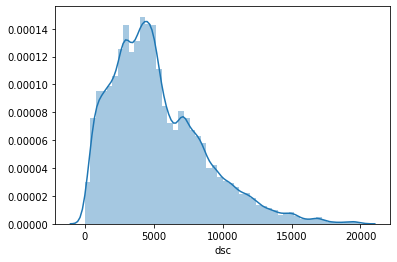

In [0]:
train_df = train_df[train_df['dsc']<20000]
sns.distplot(train_df['dsc'])

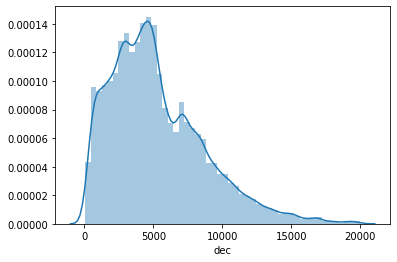

In [0]:
train_df = train_df[train_df['dec']<20000]
sns.distplot(train_df['dec'])

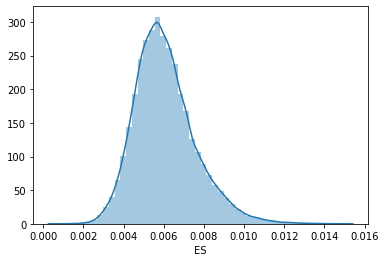

In [0]:
train_df = train_df[train_df['ES']<0.015]
sns.distplot(train_df['ES'])

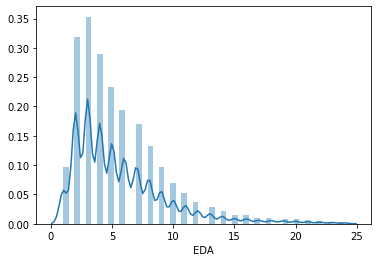

In [0]:
train_df = train_df[train_df['EDA']<25]
sns.distplot(train_df['EDA'])

# Targets

In [0]:
# new targets

for df in [train_df, validation_df]:
  # RTA-ETA 
  df['delta'] = df.RTA - df.ETA

  # RTA//ETA 
  df['prop'] = df.RTA/df.ETA

  # (RTA-ETA)//ETA
  df['dp'] = (df.RTA - df.ETA)/df.ETA

  df['logRTA'] = np.log(df['RTA'])


targets = ['RTA', 'delta', 'prop', 'dp']

# Data pools


In [0]:
target = 'RTA'

train_pool = Pool(
    data=train_df[features],
    label=train_df[target],
    cat_features=cat_features
)


val_pool = Pool(
    data=validation_df[features],
    label=validation_df[target],
    cat_features=cat_features
)

# Train straight


In [0]:
model = CatBoostRegressor(
    random_seed=42,
    iterations=1000,
    # eval_metric='MAE',
    eval_metric='MAPE',
    depth=6, # def 
    l2_leaf_reg=5.0, # def 3.0
    model_size_reg=0.5, # def 0.5
    early_stopping_rounds=100,
)


model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=100
);

print(f'Tree count: ', model.tree_count_)
print(f'Features & importance: ', list(zip(model.feature_names_, model.feature_importances_)))

0:	learn: 0.5858336	test: 0.5686776	best: 0.5686776 (0)	total: 82.2ms	remaining: 1m 22s
100:	learn: 0.1961081	test: 0.1965801	best: 0.1965801 (100)	total: 6.67s	remaining: 59.4s
200:	learn: 0.1717543	test: 0.1736045	best: 0.1736045 (200)	total: 13s	remaining: 51.8s
300:	learn: 0.1662694	test: 0.1687943	best: 0.1687943 (300)	total: 19.2s	remaining: 44.5s
400:	learn: 0.1637654	test: 0.1667440	best: 0.1667440 (400)	total: 25.3s	remaining: 37.8s
500:	learn: 0.1623561	test: 0.1657899	best: 0.1657899 (500)	total: 31.4s	remaining: 31.2s
600:	learn: 0.1614464	test: 0.1652153	best: 0.1652153 (600)	total: 37.1s	remaining: 24.6s
700:	learn: 0.1606988	test: 0.1648621	best: 0.1648621 (700)	total: 42.7s	remaining: 18.2s
800:	learn: 0.1600760	test: 0.1644446	best: 0.1644446 (800)	total: 48.1s	remaining: 12s
900:	learn: 0.1595748	test: 0.1641480	best: 0.1641480 (900)	total: 54.2s	remaining: 5.96s
999:	learn: 0.1591764	test: 0.1639638	best: 0.1639638 (999)	total: 1m	remaining: 0us

bestTest = 0.1639637

In [0]:
# RTA = train_df['ETA']*(1+model.predict(train_df[features]))
# MAPE = np.mean(np.abs((RTA-train_df['ETA'])/train_df['ETA']))
# print(MAPE)

0.139016168165057


In [0]:
# pred = np.exp(model.predict(train_df[features]))
# MAPE = np.mean(np.abs((pred-train_df['RTA'])/train_df['RTA']))
# print(MAPE)

0.14956979130329473


In [0]:
pred = model.predict(train_df[features])
MAPE = np.mean(np.abs((pred-train_df['RTA'])/train_df['RTA']))
print(MAPE)

0.15873914078512516


# Feature importance


In [0]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_df[features])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


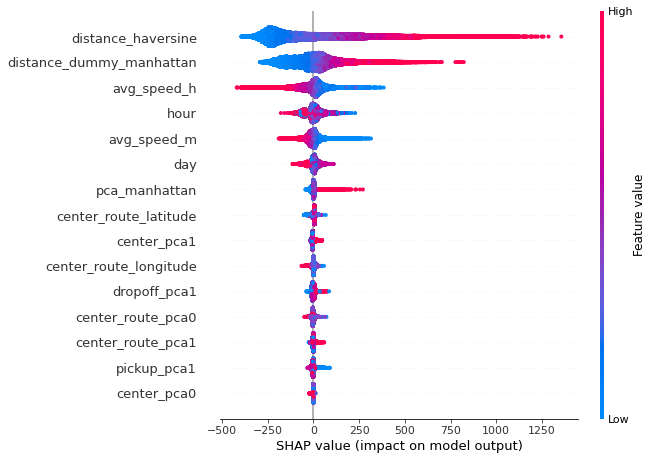

In [0]:
shap.summary_plot(shap_values, train_df[features])

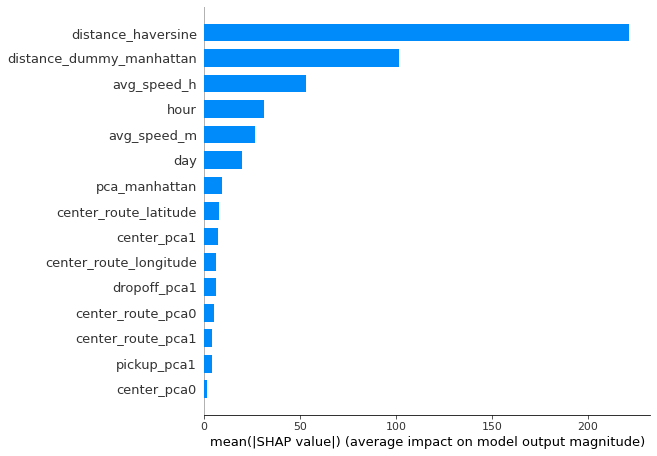

In [0]:
shap.summary_plot(shap_values, train_df[features], plot_type="bar")

target: RTA
Validation MAPE:  0.1639637515704222


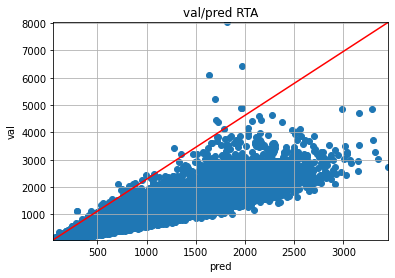

In [0]:
# Sanity check of MAPE

pred = model.predict(validation_df[features])


def plot_scatter_compare(x, y, xlabel, ylabel, title):
    plt.scatter(x, y)
    min_x = min(x)
    max_x = max(x)
    min_y = min(y)
    max_y = max(y)
    plt.plot([min_x, max_x], [min_y, max_y], color='red')
    plt.xlim([min_x, max_x])
    plt.ylim([min_y, max_y])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()
    plt.close()
    
print(f"target: {target}")
print("Validation MAPE: ", np.mean(np.abs((pred-validation_df[target])/validation_df[target])))
plot_scatter_compare(pred, validation_df[target], 'pred', 'val', f'val/pred {target}')

# Inference

In [0]:
test_df.head(5)

,Id,main_id_locality,ETA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,center_latitude,center_longitude,route,dsc,dec,day,hour,Prediction,prop1/2,ES
0,0,22394,512.0,2020-03-25 15:31:11,53.523811,53.534779,49.433762,49.407429,3.0,53.516670,49.416670,kyteI}~ulHPeB??_DwAkS{ImEqB??sAdMeClToF`g@??}B...,1384.505561,2106.540826,2,15,543.117989,0.657241,0.005859
1,1,338,1412.0,2020-03-24 09:42:57,45.017639,45.015491,39.052959,38.972431,8.0,45.040235,38.976080,iowqGcpjmFuAv@cCfA}@d@??oCzAuAn@[R{@x@_@f@]j@]...,6558.421420,2764.799710,1,9,1369.504754,2.372114,0.005666
2,2,22406,453.0,2020-03-28 15:06:29,56.806709,56.828491,60.598370,60.587620,3.0,56.838633,60.605489,cavyImtzpJCq@??{AZe@P??`Bx\??K^Aj@@z@KpBQt@??}...,3581.353754,1570.077152,5,15,595.717106,2.281005,0.006623
3,3,22402,1288.0,2020-03-28 22:34:16,54.780891,54.837189,55.892551,56.004501,15.0,54.734853,55.957865,qkjmImoctI^GXHRt@RhB??fAm@`CmB??b@~B`BvJ??jF}C...,6629.137864,11780.448165,5,22,1222.400724,0.562724,0.011646
4,4,22402,276.0,2020-03-26 19:05:37,54.757198,54.749271,56.021992,56.029621,2.0,54.734853,55.957865,ywemIix|tIYqDg@gAwAy@Ih@??aB}AWiA??bJuCjDkAlFa...,4820.924792,4892.186554,3,19,341.922810,0.985434,0.007246


In [0]:
test_df['Prediction'] = model.predict(test_df[features])
# test_df['Prediction'] = test_df['ETA']*(1+model.predict(test_df[features]))
# test_df['Prediction'] = np.exp(model.predict(test_df[features]))

result = test_df[['Id', 'Prediction']]
result.to_csv('drive/My Drive/Colab Notebooks/citymobil/submission.csv', index=False)
result.head(5)

,Id,Prediction
0,0,953.148468
1,1,708.760183
2,2,382.606549
3,3,727.908554
4,4,1325.472884
